In [2]:
# load data
import pandas as pd
import numpy as np

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# modelling
import statsmodels.formula.api as smf
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, cross_validate, KFold

In [3]:
#make function to estimated coef

def print_coef_std_err(results):
    """
    Function to combine estimated coefficients and standard error in one DataFrame
    :param results: <statsmodels RegressionResultsWrapper> OLS regression results from statsmodel library
    :return df: <pandas DataFrame> 
    """
    coef = results.params
    std_err = results.bse
    
    df = pd.DataFrame(data = np.transpose([coef, std_err]), 
                      index = coef.index, 
                      columns=["coef","std err"])
    return df

class StatsmodelsRegressor(BaseEstimator, RegressorMixin):
    """ A universal sklearn-style wrapper for statsmodels regressors """
    
    def __init__(self, sm_class, sm_formula):
        self.sm_class = sm_class
        self.sm_formula = sm_formula
        self.model = None
        self.result = None
 
    def fit(self, data, dummy):
        self.model = self.sm_class(self.sm_formula, data)
        self.result = self.model.fit()
 
    def predict(self,X):
        return self.result.predict(X)


#make function to kfold estimated
def kfold_split(data, n_fold):
    """
    Function to combine estimated coefficients and standard error in one DataFrame
    :param results: <statsmodels RegressionResultsWrapper> OLS regression results from statsmodel
    :param n_fold: <int> Number of fold in k-fold CV
    :return df: <pandas DataFrame>  combined estimated coefficient and standard error of model estimate
    """
    kfold = KFold(n_splits = n_fold, 
                  shuffle = True, 
                  random_state=123)
    fold_train = {}
    fold_test = {}

    for i, (train, test) in enumerate(kfold.split(data)):
        print(f"fold {i+1}, train data rows: {len(train)}, test data rows: {len(test)}")
        fold_train[i] = data.iloc[train].copy()
        fold_test[i] = data.iloc[test].copy()
        
    return (fold_train, fold_test)

In [4]:
#initialize to read the dataset

car_ad = pd.read_csv('car_ad.csv', encoding='ISO-8859-1').dropna()

In [5]:
#EDA

car_ad.head()

,car,price,body,mileage,engV,engType,registration,year,model,drive
0,Ford,15500.0,crossover,68,2.5,Gas,yes,2010,Kuga,full
1,Mercedes-Benz,20500.0,sedan,173,1.8,Gas,yes,2011,E-Class,rear
2,Mercedes-Benz,35000.0,other,135,5.5,Petrol,yes,2008,CL 550,rear
3,Mercedes-Benz,17800.0,van,162,1.8,Diesel,yes,2012,B 180,front
5,Nissan,16600.0,crossover,83,2.0,Petrol,yes,2013,X-Trail,full


In [6]:
#EDA
car_ad.shape

(8739, 10)

In [7]:
#EDA
car_ad.describe()

,price,mileage,engV,year
count,8739.000000,8739.000000,8739.000000,8739.000000
mean,15733.542261,140.095434,2.588607,2006.609681
std,24252.904810,97.892213,5.416670,6.968947
min,0.000000,0.000000,0.100000,1959.000000
25%,5000.000000,71.000000,1.600000,2004.000000
50%,9250.000000,130.000000,2.000000,2008.000000
75%,16800.000000,195.500000,2.500000,2012.000000
max,547800.000000,999.000000,99.990000,2016.000000


In [8]:
#EDA
car_ad.dtypes

car              object
price           float64
body             object
mileage           int64
engV            float64
engType          object
registration     object
year              int64
model            object
drive            object
dtype: object

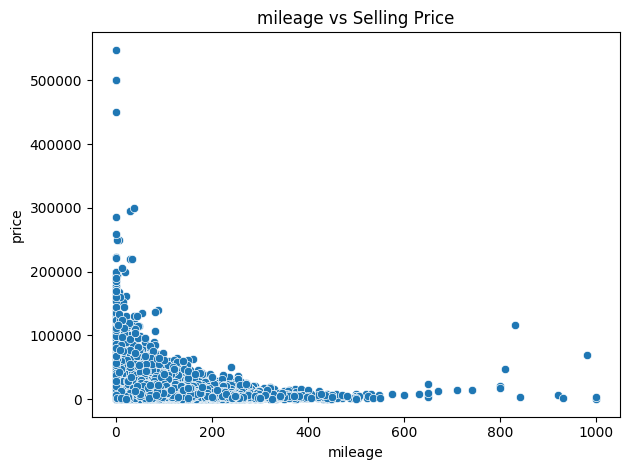

In [9]:
#EDA
# Make visualization for variable Year vs variable Selling Price
plt.subplot(1, 1, 1)
sns.scatterplot(data=car_ad, x='mileage', y='price')
plt.title('mileage vs Selling Price')
plt.tight_layout()
plt.show()

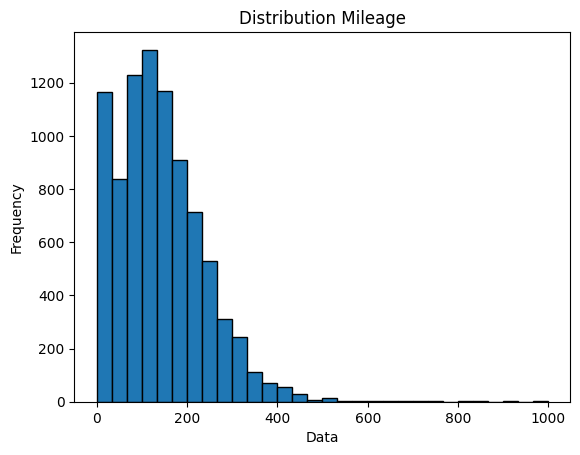

In [10]:
#EDA
# Make Visualization for Distribution value mileage
plt.hist(car_ad[["mileage"]], bins=30, edgecolor='black')
plt.title('Distribution Mileage')
plt.xlabel('Data')
plt.ylabel('Frequency')
plt.show()

In [11]:
#EDA
#Divide the category of float64 & int64
car_ad_num = car_ad.select_dtypes(include=['float64','int64'])

In [12]:
#EDA
#Make Corelation table for numeric variable
correlation_matrix= car_ad_num.corr()
correlations_with_selling_price = correlation_matrix['price'].sort_values(ascending=False)
correlations_with_selling_price

price      1.000000
year       0.373165
engV       0.062118
mileage   -0.317817
Name: price, dtype: float64

In [13]:
# Create OLS model object
model = smf.ols("price ~ mileage", car_ad_num)

# Fit the model
results = model.fit()

# Extract the results (Coefficient and Standard Error) to DataFrame
results_mileage = print_coef_std_err(results)
results_mileage

,coef,std err
Intercept,26764.572596,429.504078
mileage,-78.739399,2.513116


$$\text{Selling Price} = 26764 -78.739\times\text{mileage}$$

In [14]:
expected_mileage_50 = results_mileage["coef"]["Intercept"]+results_mileage["coef"]["mileage"]*50
expected_mileage_50

22827.602632474867

In [15]:
expected_mileage_100 = results_mileage["coef"]["Intercept"]+results_mileage["coef"]["mileage"]*100
expected_mileage_100

18890.63266874251

In [16]:
diff_50Km = expected_mileage_50-expected_mileage_100
diff_50Km

3936.9699637323574

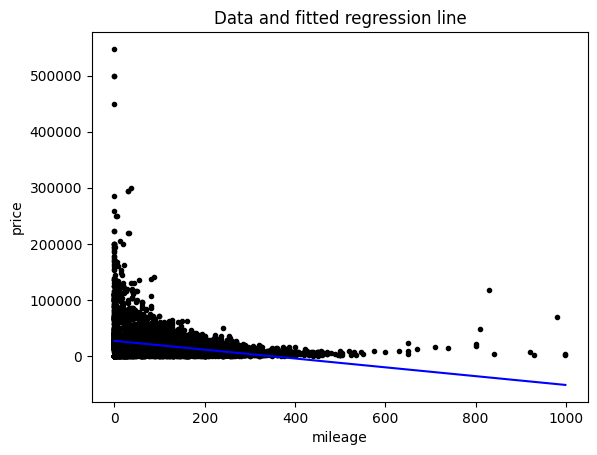

In [17]:
predictor = "mileage"
outcome = "price"
data = car_ad_num.copy()
results_ = results_mileage.copy()

# Plot the data
plt.scatter(data[predictor], data[outcome], color = "k", marker=".")

# Calculate the fitted values
a_hat = results_.loc["Intercept"]["coef"]
b_hat = results_.loc[predictor]["coef"]

x_domain = np.linspace(np.min(data[predictor]), np.max(data[predictor]), 10000)

fitted_values = a_hat + b_hat * x_domain

# Plot the fitted line
plt.plot(x_domain, fitted_values, label="Fitted line", color = "b")

# Add a legend and labels
# plt.legend()
plt.ylabel(outcome)
plt.xlabel(predictor)

# Add a title and adjust the margins
plt.title("Data and fitted regression line")

# Show the plot
plt.show()

Text(0.5, 1.0, 'Residuals vs. Predicted mpg')

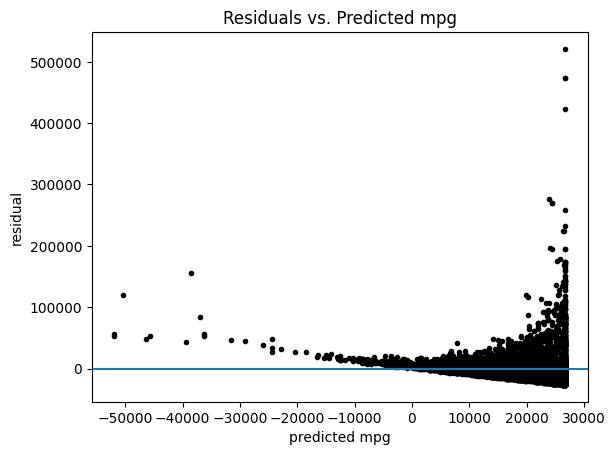

In [18]:
plt.scatter(results.fittedvalues, results.resid, marker=".", c = "k")

# Plot the horizontal line in 0 as the fitted line
plt.axhline([0])

plt.xlabel("predicted mpg")
plt.ylabel("residual")
plt.title(f"Residuals vs. Predicted mpg")

In [19]:
results.rsquared

0.1010073467366539

In [20]:
X = car_ad_num[['mileage']]  
y = car_ad_num['price']      

# Split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

# train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict the model
y_pred = model.predict(X_test)

# evaluation section with R-squared
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"R-squared: {r2}")
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")

R-squared: 0.10305495177901969
Mean Squared Error: 554438152.4905492
Root Mean Squared Error: 23546.510410049068


In [21]:
model_SMF = StatsmodelsRegressor(smf.ols, "price ~ mileage")

In [22]:
kfold = KFold(n_splits=5, shuffle = True, random_state=123)

In [23]:
Val_model_smf = cross_val_score(estimator = model_SMF,
                                       X = car_ad_num,
                                       y = car_ad_num["price"],
                                       cv = kfold,
                                       scoring = "r2")
Val_model_smf = pd.DataFrame(data = Val_model_smf, 
                                    columns=["test_rsquared"])
Val_model_smf["folds"] = [f"Folds {i+1}" for i in range(5)]
Val_model_smf

,test_rsquared,folds
0,0.107494,Folds 1
1,0.095462,Folds 2
2,0.075075,Folds 3
3,0.103682,Folds 4
4,0.126160,Folds 5
